# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret

In [2]:
# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters

In [3]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [4]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [5]:
params = vaep.nb.get_params(args, globals=globals())
params

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


{'folder_data': '',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'folder_experiment': 'runs/alzheimer_study',
 'model_key': 'DAE',
 'target': 'AD',
 'sample_id_col': 'Sample ID',
 'cutoff_target': 0.5,
 'file_format': 'csv',
 'out_folder': 'diff_analysis',
 'fn_qc_samples': '',
 'baseline': 'PI',
 'template_pred': 'pred_real_na_{}.csv'}

In [6]:
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
args

root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

In [7]:
files_out = dict()

## Load target

In [8]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### Measured data

In [9]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_110  Q9UQM7            16.098
Sample_001  P35443            15.644
Sample_136  P05408-2          19.373
Sample_209  A0A075B6K5        16.989
Sample_198  F8W876;P48740-3   15.373
Name: intensity, dtype: float64

Get overlap between independent features and target

### Load ALD data or create

In [10]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [11]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load semi-supervised model imputations

In [12]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups
Sample_097  P07196           12.671
Sample_059  P62805           15.948
Sample_192  P13647           15.585
Name: intensity, dtype: float64

In [13]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.864
            A0A075B6Q5                 12.824
            A0A075B6R2                 14.377
            A0A075B6S5                 12.867
            A0A087WSY4                 13.261
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.135
            Q9UI40;Q9UI40-2            12.264
            Q9UIW2                     12.081
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.723
            Q9UP79                     11.536
Name: intensity, Length: 46401, dtype: float64

## Model predictions
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
3. newly available feat only: the subset of features available from the
self supervised deep learning model which were newly retained using the
new approach

In [14]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.514,15.050,16.842,19.863,15.964,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.632,19.067,...,15.528,15.576,14.388,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.877,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.922,17.705,17.039,15.521,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.267,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.976,15.345,17.084,18.708,14.249,19.433,11.066,10.783
Sample_207,15.739,16.877,15.469,16.898,13.896,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [15]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.864,...,16.012,15.178,13.415,15.050,16.842,19.863,13.477,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.554,19.067,16.188,...,15.528,15.576,13.143,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.862,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.685,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.334,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.652,15.345,17.084,18.708,14.249,19.433,13.733,12.037
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


In [16]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification


In [17]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Best number of parameters by CV

In [18]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 323.11it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.04it/s]

100%|██████████| 2/2 [00:00<00:00,  4.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.67it/s]

100%|██████████| 3/3 [00:01<00:00,  2.59it/s]

100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.59it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.67it/s]

100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.16it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.18it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.94it/s]

100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

100%|██████████| 5/5 [00:01<00:00,  3.06it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.02it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.02it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.62it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.36it/s]

100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

100%|██████████| 6/6 [00:02<00:00,  2.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.19it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.72it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.27it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.08it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.07it/s]

100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

100%|██████████| 7/7 [00:03<00:00,  2.25it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.31it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.96it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.29it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.72it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.59it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.66it/s]

100%|██████████| 8/8 [00:02<00:00,  2.72it/s]

100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.21it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.00it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.30it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.06it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  1.91it/s]

 78%|███████▊  | 7/9 [00:03<00:01,  1.97it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.16it/s]

100%|██████████| 9/9 [00:03<00:00,  2.20it/s]

100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.92it/s]

 30%|███       | 3/10 [00:00<00:02,  3.25it/s]

 40%|████      | 4/10 [00:01<00:02,  2.71it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.58it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.58it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.71it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.74it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.72it/s]

100%|██████████| 10/10 [00:03<00:00,  2.64it/s]

100%|██████████| 10/10 [00:03<00:00,  2.79it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.14it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.47it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.82it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.49it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.43it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.30it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.16it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.03it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.05it/s]

100%|██████████| 11/11 [00:04<00:00,  2.09it/s]

100%|██████████| 11/11 [00:04<00:00,  2.35it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.82it/s]

 25%|██▌       | 3/12 [00:01<00:03,  2.57it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.05it/s]

 42%|████▏     | 5/12 [00:02<00:03,  1.90it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.91it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  2.03it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.13it/s]

 75%|███████▌  | 9/12 [00:04<00:01,  2.29it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.27it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.22it/s]

100%|██████████| 12/12 [00:05<00:00,  2.30it/s]

100%|██████████| 12/12 [00:05<00:00,  2.22it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.80it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.89it/s]

 31%|███       | 4/13 [00:01<00:02,  3.30it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.06it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.55it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.32it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.18it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.26it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.33it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.57it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.71it/s]

100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

100%|██████████| 13/13 [00:04<00:00,  2.71it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.15it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.69it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.45it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.27it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.80it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.62it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.47it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.33it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.52it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.63it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.72it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.73it/s]

100%|██████████| 14/14 [00:05<00:00,  2.43it/s]

100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.72it/s]

 20%|██        | 3/15 [00:00<00:02,  4.46it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.91it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.58it/s]

 40%|████      | 6/15 [00:01<00:03,  2.97it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.54it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.43it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.37it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.06it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.00it/s]

 80%|████████  | 12/15 [00:04<00:01,  1.91it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.92it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.01it/s]

100%|██████████| 15/15 [00:06<00:00,  2.18it/s]

100%|██████████| 15/15 [00:06<00:00,  2.42it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.049 0.010          0.756 0.355       0.114   
2             0.004 0.003      0.054 0.013          0.697 0.118       0.638   
3             0.004 0.000      0.052 0.015          0.706 0.117       0.624   
4             0.005 0.003      0.058 0.020          0.694 0.115       0.609   
5             0.005 0.005      0.060 0.019          0.727 0.108       0.647   
6             0.005 0.003      0.056 0.018          0.715 0.099       0.669   
7             0.005 0.004      0.062 0.024          0.795 0.092       0.798   
8             0.006 0.004      0.066 0.028          0.791 0.092       0.797   
9             0.005 0.003      0.062 0.022          0.797 0.091       0.804   
10            0.006 0.005      0.067 0.024          0.810 0.079       0.831   
11            0.005 0.004      0.055 0.021          0.813 0.076       0.823   
12            0.004 0.002      0.055 0.016          0.822 0.085       0.830   
13            0.006 0.005      0.069 0.030          0.821 0.085       0.825   
14            0.007 0.005      0.075 0.030          0.818 0.090       0.815   
15            0.005 0.003      0.058 0.018          0.814 0.089       0.813   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.192 0.126                  0.550 0.040        0.849   
2          0.124   0.657 0.090                  0.712 0.073        0.788   
3          0.135   0.653 0.099                  0.712 0.078        0.791   
4          0.134   0.639 0.096                  0.701 0.074        0.786   
5          0.106   0.677 0.078                  0.730 0.061        0.823   
6          0.112   0.685 0.082                  0.734 0.066        0.822   
7          0.107   0.791 0.074                  0.821 0.062        0.899   
8          0.109   0.788 0.074                  0.819 0.063        0.897   
9          0.102   0.795 0.073                  0.825 0.062        0.896   
10         0.107   0.816 0.068                  0.843 0.058        0.904   
11         0.099   0.813 0.065                  0.841 0.055        0.906   
12         0.094   0.823 0.071                  0.848 0.061        0.909   
13         0.097   0.820 0.074                  0.846 0.063        0.908   
14         0.098   0.813 0.074                  0.840 0.064        0.905   
15         0.098   0.809 0.071                  0.837 0.061        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.088        210.000 0.000  
2          0.073                  0.731 0.092        210.000 0.000  
3          0.076                  0.729 0.095        210.000 0.000  
4          0.077                  0.718 0.097        210.000 0.000  
5          0.064                  0.784 0.088        210.000 0.000  
6          0.066                  0.779 0.092        210.000 0.000  
7          0.051                  0.878 0.060        210.000 0.000  
8          0.051                  0.876 0.060        210.000 0.000  
9          0.051                  0.876 0.058        210.000 0.000  
10         0.051                  0.890 0.056        210.000 0.000  
11         0.051                  0.895 0.056        210.000 0.000  
12         0.052                  0.900 0.053        210.000 0.000  
13         0.052                  0.899 0.053        210.000 0.000  
14         0.054                  0.896 0.055        210.000 0.000  
15         0.053                  0.894 0.056 

In [19]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 486.97it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

100%|██████████| 2/2 [00:00<00:00,  5.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.31it/s]

100%|██████████| 3/3 [00:00<00:00,  2.92it/s]

100%|██████████| 3/3 [00:00<00:00,  3.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.65it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.74it/s]

100%|██████████| 4/4 [00:01<00:00,  2.98it/s]

100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.00it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.38it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.99it/s]

100%|██████████| 5/5 [00:01<00:00,  2.60it/s]

100%|██████████| 5/5 [00:01<00:00,  2.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.29it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.69it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.66it/s]

100%|██████████| 6/6 [00:02<00:00,  2.28it/s]

100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.60it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.69it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.23it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.10it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.00it/s]

100%|██████████| 7/7 [00:02<00:00,  2.52it/s]

100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.09it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.45it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.04it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.80it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.34it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.02it/s]

100%|██████████| 8/8 [00:03<00:00,  1.99it/s]

100%|██████████| 8/8 [00:03<00:00,  2.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.86it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.19it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.62it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.25it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.15it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.43it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.11it/s]

100%|██████████| 9/9 [00:03<00:00,  1.93it/s]

100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.67it/s]

 30%|███       | 3/10 [00:00<00:01,  4.12it/s]

 40%|████      | 4/10 [00:01<00:01,  3.38it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.07it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.06it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.21it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.12it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.13it/s]

100%|██████████| 10/10 [00:03<00:00,  2.15it/s]

100%|██████████| 10/10 [00:03<00:00,  2.54it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.45it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.98it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.53it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.28it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.02it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.36it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.22it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.07it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.07it/s]

100%|██████████| 11/11 [00:04<00:00,  2.14it/s]

100%|██████████| 11/11 [00:04<00:00,  2.51it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.77it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.14it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.48it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.18it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.89it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.26it/s]

 67%|██████▋   | 8/12 [00:03<00:02,  1.87it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  1.84it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.96it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.10it/s]

100%|██████████| 12/12 [00:05<00:00,  2.21it/s]

100%|██████████| 12/12 [00:05<00:00,  2.40it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.76it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.08it/s]

 31%|███       | 4/13 [00:01<00:02,  3.52it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.21it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.66it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.40it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.06it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.99it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.92it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.00it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.03it/s]

100%|██████████| 13/13 [00:05<00:00,  2.17it/s]

100%|██████████| 13/13 [00:05<00:00,  2.38it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.84it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.89it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.94it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.81it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.71it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.82it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.47it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.29it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.18it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.03it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.09it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.35it/s]

100%|██████████| 14/14 [00:05<00:00,  2.34it/s]

100%|██████████| 14/14 [00:05<00:00,  2.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.49it/s]

 20%|██        | 3/15 [00:00<00:03,  3.62it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.18it/s]

 33%|███▎      | 5/15 [00:01<00:03,  3.09it/s]

 40%|████      | 6/15 [00:01<00:03,  2.97it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.01it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.06it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.81it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.69it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.61it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.68it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.69it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.69it/s]

100%|██████████| 15/15 [00:07<00:00,  1.65it/s]

100%|██████████| 15/15 [00:07<00:00,  2.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.007      0.076 0.036          0.087 0.248       0.009   
2             0.004 0.002      0.065 0.026          0.690 0.091       0.512   
3             0.006 0.005      0.079 0.033          0.713 0.091       0.540   
4             0.006 0.006      0.073 0.026          0.767 0.117       0.611   
5             0.005 0.005      0.058 0.029          0.732 0.092       0.648   
6             0.007 0.006      0.079 0.029          0.719 0.094       0.641   
7             0.006 0.004      0.072 0.024          0.722 0.088       0.654   
8             0.004 0.002      0.064 0.024          0.808 0.092       0.758   
9             0.004 0.003      0.059 0.018          0.802 0.093       0.762   
10            0.004 0.002      0.060 0.018          0.798 0.100       0.780   
11            0.005 0.004      0.056 0.018          0.811 0.094       0.797   
12            0.004 0.002      0.059 0.020          0.831 0.094       0.801   
13            0.005 0.003      0.059 0.018          0.834 0.092       0.802   
14            0.006 0.004      0.059 0.019          0.835 0.092       0.806   
15            0.005 0.003      0.061 0.020          0.833 0.093       0.805   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.017 0.048                  0.501 0.012        0.863   
2          0.107   0.580 0.083                  0.670 0.052        0.723   
3          0.130   0.605 0.096                  0.689 0.060        0.748   
4          0.113   0.672 0.088                  0.734 0.065        0.799   
5          0.112   0.681 0.079                  0.735 0.059        0.803   
6          0.110   0.671 0.080                  0.727 0.060        0.800   
7          0.124   0.680 0.088                  0.734 0.065        0.804   
8          0.100   0.777 0.072                  0.811 0.057        0.887   
9          0.105   0.775 0.074                  0.809 0.059        0.886   
10         0.115   0.782 0.079                  0.815 0.066        0.913   
11         0.125   0.797 0.084                  0.829 0.070        0.915   
12         0.114   0.810 0.084                  0.839 0.069        0.919   
13         0.108   0.813 0.080                  0.841 0.066        0.920   
14         0.108   0.816 0.079                  0.843 0.066        0.920   
15         0.113   0.813 0.082                  0.842 0.068        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.830 0.087        210.000 0.000  
2          0.071                  0.710 0.076        210.000 0.000  
3          0.069                  0.694 0.086        210.000 0.000  
4          0.066                  0.774 0.082        210.000 0.000  
5          0.065                  0.772 0.084        210.000 0.000  
6          0.066                  0.768 0.085        210.000 0.000  
7          0.071                  0.772 0.089        210.000 0.000  
8          0.054                  0.866 0.064        210.000 0.000  
9          0.056                  0.865 0.066        210.000 0.000  
10         0.048                  0.884 0.063        210.000 0.000  
11         0.047                  0.886 0.063        210.000 0.000  
12         0.046                  0.896 0.059        210.000 0.000  
13         0.046                  0.899 0.056        210.000 0.000  
14         0.046                  0.898 0.056        210.000 0.000  
15         0.046                  0.898 0.055 

In [20]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 996.27it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 18.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.39it/s]

100%|██████████| 3/3 [00:00<00:00, 16.31it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 18.55it/s]

100%|██████████| 4/4 [00:00<00:00, 12.69it/s]

100%|██████████| 4/4 [00:00<00:00, 12.73it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 15.67it/s]

100%|██████████| 5/5 [00:00<00:00, 10.14it/s]

100%|██████████| 5/5 [00:00<00:00, 10.68it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 16.70it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 13.60it/s]

100%|██████████| 6/6 [00:00<00:00, 13.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 14.60it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 11.29it/s]

100%|██████████| 7/7 [00:00<00:00,  9.96it/s]

100%|██████████| 7/7 [00:00<00:00, 10.60it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 14.18it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 12.22it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.02it/s]

100%|██████████| 8/8 [00:00<00:00, 12.15it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 16.37it/s]

 44%|████▍     | 4/9 [00:00<00:00, 11.77it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 10.46it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.22it/s]

100%|██████████| 9/9 [00:00<00:00, 11.08it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 17.29it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.83it/s]

 70%|███████   | 7/10 [00:00<00:00, 12.28it/s]

 90%|█████████ | 9/10 [00:00<00:00, 10.06it/s]

100%|██████████| 10/10 [00:00<00:00, 10.93it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 14.49it/s]

 45%|████▌     | 5/11 [00:00<00:00, 11.12it/s]

 64%|██████▎   | 7/11 [00:00<00:00,  9.06it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  8.59it/s]

 82%|████████▏ | 9/11 [00:00<00:00,  8.82it/s]

100%|██████████| 11/11 [00:01<00:00,  9.52it/s]

100%|██████████| 11/11 [00:01<00:00,  9.56it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 17.34it/s]

 33%|███▎      | 4/12 [00:00<00:00, 10.54it/s]

 50%|█████     | 6/12 [00:00<00:00,  9.16it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  8.88it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.84it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  7.82it/s]

100%|██████████| 12/12 [00:01<00:00, 10.00it/s]

100%|██████████| 12/12 [00:01<00:00,  9.55it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 14.10it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.32it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 13.33it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 13.15it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.29it/s]

100%|██████████| 13/13 [00:01<00:00, 12.11it/s]

100%|██████████| 13/13 [00:01<00:00, 12.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 17.15it/s]

 29%|██▊       | 4/14 [00:00<00:00, 11.93it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.95it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 10.64it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 10.31it/s]

 86%|████████▌ | 12/14 [00:01<00:00, 10.64it/s]

100%|██████████| 14/14 [00:01<00:00, 10.92it/s]

100%|██████████| 14/14 [00:01<00:00, 10.89it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 17.81it/s]

 27%|██▋       | 4/15 [00:00<00:00, 12.52it/s]

 40%|████      | 6/15 [00:00<00:00,  9.99it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.62it/s]

 67%|██████▋   | 10/15 [00:00<00:00,  9.53it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  9.58it/s]

 80%|████████  | 12/15 [00:01<00:00,  9.13it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  8.91it/s]

100%|██████████| 15/15 [00:01<00:00,  8.97it/s]

100%|██████████| 15/15 [00:01<00:00,  9.62it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.060 0.022          0.000 0.000       0.000   
2             0.007 0.005      0.079 0.033          0.712 0.197       0.180   
3             0.004 0.002      0.058 0.021          0.600 0.157       0.268   
4             0.005 0.005      0.073 0.033          0.586 0.158       0.253   
5             0.006 0.005      0.062 0.024          0.607 0.156       0.286   
6             0.004 0.002      0.048 0.014          0.566 0.146       0.314   
7             0.003 0.001      0.043 0.016          0.548 0.153       0.304   
8             0.005 0.003      0.055 0.017          0.658 0.089       0.610   
9             0.004 0.001      0.047 0.005          0.642 0.085       0.595   
10            0.005 0.004      0.065 0.028          0.690 0.077       0.680   
11            0.005 0.003      0.061 0.023          0.696 0.070       0.664   
12            0.006 0.005      0.066 0.023          0.694 0.073       0.656   
13            0.008 0.007      0.077 0.036          0.694 0.073       0.662   
14            0.005 0.003      0.064 0.022          0.696 0.073       0.663   
15            0.007 0.005      0.073 0.030          0.694 0.069       0.662   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.756   
2          0.069   0.275 0.087                  0.554 0.034        0.572   
3          0.092   0.361 0.107                  0.565 0.057        0.590   
4          0.087   0.343 0.099                  0.555 0.052        0.571   
5          0.092   0.378 0.098                  0.569 0.054        0.576   
6          0.088   0.397 0.095                  0.564 0.062        0.586   
7          0.087   0.382 0.094                  0.553 0.063        0.575   
8          0.101   0.627 0.078                  0.687 0.059        0.772   
9          0.104   0.612 0.078                  0.675 0.057        0.767   
10         0.109   0.680 0.077                  0.728 0.062        0.800   
11         0.125   0.674 0.084                  0.726 0.063        0.838   
12         0.124   0.668 0.085                  0.722 0.064        0.835   
13         0.124   0.671 0.084                  0.724 0.064        0.832   
14         0.129   0.672 0.087                  0.725 0.065        0.830   
15         0.131   0.670 0.087                  0.724 0.064        0.824   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.703 0.085        210.000 0.000  
2          0.066                  0.567 0.061        210.000 0.000  
3          0.071                  0.576 0.066        210.000 0.000  
4          0.067                  0.557 0.065        210.000 0.000  
5          0.075                  0.558 0.074        210.000 0.000  
6          0.080                  0.561 0.084        210.000 0.000  
7          0.084                  0.549 0.088        210.000 0.000  
8          0.061                  0.710 0.079        210.000 0.000  
9          0.057                  0.702 0.074        210.000 0.000  
10         0.062                  0.741 0.083        210.000 0.000  
11         0.053                  0.787 0.069        210.000 0.000  
12         0.053                  0.782 0.069        210.000 0.000  
13         0.053                  0.779 0.069        210.000 0.000  
14         0.053                  0.775 0.069        210.000 0.000  
15         0.052                  0.765 0.068 

In [21]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,6,13
score_time,14,6,2
test_precision,12,14,2
test_recall,10,14,10
test_f1,12,14,10
test_balanced_accuracy,12,14,10
test_roc_auc,12,14,11
test_average_precision,12,13,11
n_observations,1,1,1


## Train, test split

In [22]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

In [23]:
njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


In [24]:
y_train.value_counts()

AD   
False   98
True    70
Name: count, dtype: int64

## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

In [25]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.76it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.04it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.56it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.53it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.11it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.79it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.63it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.68it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.79it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.68it/s]

 86%|████████▌ | 12/14 [00:06<00:01,  1.61it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.55it/s]

100%|██████████| 14/14 [00:07<00:00,  1.66it/s]

100%|██████████| 14/14 [00:07<00:00,  1.90it/s]

In [26]:
# all(results_model_full.test.roc.tpr
#     ==
#     vaep.sklearn.Results.from_pickle(fname).test.roc.tpr)

In [27]:
splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.78it/s]

 36%|███▋      | 4/11 [00:00<00:00, 13.04it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.53it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.98it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.69it/s]

100%|██████████| 11/11 [00:00<00:00, 11.27it/s]

In [28]:
splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  3.92it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.11it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.44it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.39it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.58it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.26it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.17it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.22it/s]

 83%|████████▎ | 10/12 [00:04<00:01,  1.90it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.78it/s]

100%|██████████| 12/12 [00:05<00:00,  1.83it/s]

100%|██████████| 12/12 [00:05<00:00,  2.15it/s]

### ROC-AUC

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


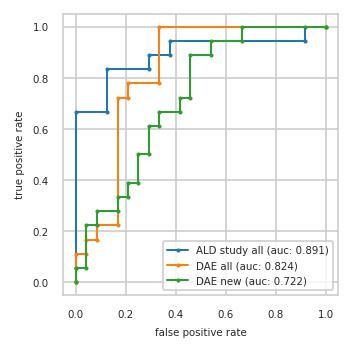

In [29]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [30]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.667   0.000 0.111   0.042 0.056
3          0.125 0.667   0.042 0.111   0.042 0.222
4          0.125 0.833   0.042 0.167   0.083 0.222
5          0.292 0.833   0.083 0.167   0.083 0.278
6          0.292 0.889   0.083 0.222   0.167 0.278
7          0.375 0.889   0.167 0.222   0.167 0.333
8          0.375 0.944   0.167 0.722   0.208 0.333
9          0.917 0.944   0.208 0.722   0.208 0.389
10         0.917 1.000   0.208 0.778   0.250 0.389
11         1.000 1.000   0.333 0.778   0.250 0.500
12           NaN   NaN   0.333 1.000   0.292 0.500
13           NaN   NaN   1.000 1.000   0.292 0.611
14           NaN   NaN     NaN   NaN   0.333 0.611
15           NaN   NaN     NaN   NaN   0.333 0.667
16           NaN   NaN     NaN   NaN   0.417 0.667
17           NaN   NaN     NaN   NaN   0.417 0.722
18           NaN   NaN     NaN   NaN   0.458 0.722
19           NaN   NaN     NaN   NaN   0.458 0.889
20           NaN   NaN     NaN   NaN   0.542 0.889
21           NaN   NaN     NaN   NaN   0.542 0.944
22           NaN   NaN     NaN   NaN   0.667 0.944
23           NaN   NaN     NaN   NaN   0.667 1.000
24           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected

In [31]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9NX62,P22676,P01704
2,Q641Q3;Q641Q3-2,F5H5D3;Q9BQE3,P51688
3,P61981,Q14894,P31321
4,P14174,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
5,P04075,Q9Y2T3;Q9Y2T3-3,Q9Y281;Q9Y281-3
6,C9JF17;P05090,P61981,Q96GD0
7,Q9Y2T3;Q9Y2T3-3,P04075,Q9NUQ9
8,Q6EMK4,P25189;P25189-2,A0A0C4DGV4;E9PLX3;O43504;R4GMU8


### Precision-Recall plot

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


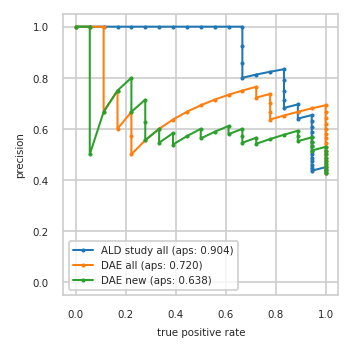

In [32]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

In [33]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.567 0.944
13         0.586 0.944     0.621 1.000     0.552 0.889
14         0.607 0.944     0.643 1.000     0.571 0.889
15         0.630 0.944     0.667 1.000     0.593 0.889
16         0.654 0.944     0.692 1.000     0.577 0.833
17         0.640 0.889     0.680 0.944     0.560 0.778
18         0.667 0.889     0.667 0.889     0.542 0.722
19         0.696 0.889     0.652 0.833     0.565 0.722
20         0.682 0.833     0.636 0.778     0.545 0.667
21         0.714 0.833     0.667 0.778     0.571 0.667
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.789 0.833     0.737 0.778     0.579 0.611
24         0.833 0.833     0.722 0.722     0.611 0.611
25         0.824 0.778     0.765 0.722     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.857 0.667     0.714 0.556     0.571 0.444
29         0.923 0.667     0.692 0.500     0.538 0.389
30         1.000 0.667     0.667 0.444     0.583 0.389
31         1.000 0.611     0.636 0.389     0.545 0.333
32         1.000 0.556     0.600 0.333     0.600 0.333
33         1.000 0.500     0.556 0.278     0.556 0.278
34         1.000 0.444     0.500 0.222     0.625 0.278
35         1.000 0.389     0.571 0.222     0.714 0.278
36         1.000 0.333     0.667 0.222     0.667 0.222
37         1.000 0.278     0.600 0.167     0.800 0.222
38         1.000 0.222     0.750 0.167     0.750 0.167
39         1.000 0.167     0.667 0.111     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


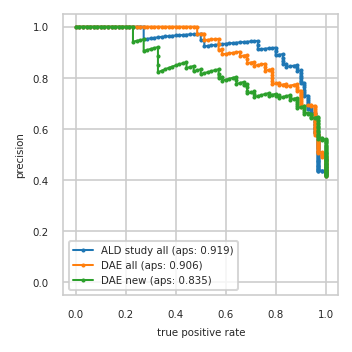

In [34]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


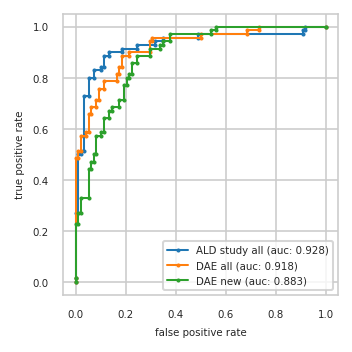

In [35]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Options:
- F1 results for test data for best cutoff on training data?
  (select best cutoff of training data, evaluate on test data)
- plot X_train PCA/UMAP, map X_test

Output files:

In [36]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}